Simple least square solve with u.n_s = v_s.n_s

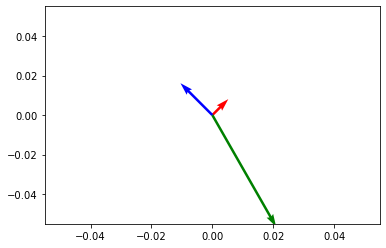

In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

V = np.array([[1,1], [-2,2], [4,-7]])
origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=21)
plt.show()

U:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
N:  [ 1.          0.          0.          1.          0.70710678  0.70710678
  0.70710678 -0.70710678 -1.          0.          0.         -1.
 -0.70710678  0.70710678 -0.70710678 -0.70710678]
cross product:  [1.         1.         0.70710678 0.        ]
B:  [1. 1. 1. 1.]
[1 1 0 1 1 0 0 0]
Uframe [ 1.          0.          0.          1.          0.70710678  0.70710678
  0.70710678 -0.70710678]


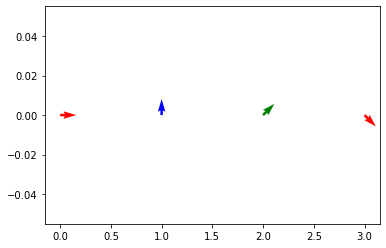

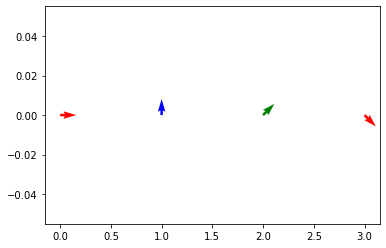

cross product:  [-2.         -2.         -1.41421356  0.        ]
B:  [1. 1. 1. 1.]
[2 2 0 2 2 0 0 0]
Uframe [-1.          0.26146661 -0.26111525 -1.         -0.89178046  0.5224331
 -0.52228997 -0.89192359]


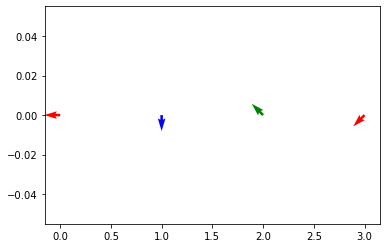

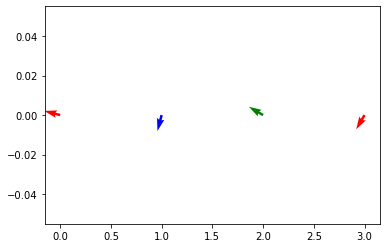

In [3]:
uInit00 = np.array([1, 1])
uInit01 = np.array([0, 1])
uInit02 = np.array([1, 0])
uInit03 = np.array([0, 0])
Uinit0 = np.concatenate([uInit00, uInit01, uInit02, uInit03])
uInit10 = np.array([2, 2])
uInit11 = np.array([0, 2])
uInit12 = np.array([2, 0])
uInit13 = np.array([0, 0])
Uinit1 = np.concatenate([uInit10, uInit11, uInit12, uInit13])
Uinit = np.concatenate([Uinit0, Uinit1])  # chosen intelligently

U = np.array([0]*Uinit.size) # don't know
print("U: ", U)

n00 = np.array([1, 0])
n01 = np.array([0, 1])
n02 = np.array([np.sqrt(2)/2, np.sqrt(2)/2])
n03 = np.array([np.sqrt(2)/2, -np.sqrt(2)/2])
N0 = np.concatenate([n00, n01, n02, n03])
n10 = np.array([-1, 0])
n11 = np.array([0, -1])
n12 = np.array([-np.sqrt(2)/2, np.sqrt(2)/2])
n13 = np.array([-np.sqrt(2)/2, -np.sqrt(2)/2])
N1 = np.concatenate([n10, n11, n12, n13])
N = np.concatenate([N0, N1])  # given as such from C++ program


print("N: ", N)

V = N  # given as such from C++ program

nbPoints = N0.size // 2  # given as such from C++ program
nbLines = 2
nbColumns = 2
nbFrames = N.size // (2 * nbPoints)  # can be deducted

origins = np.array([[i for i in range(nbPoints)], [0]*nbPoints])

#######################################################


for frameId in range(nbFrames):
    UinitFrame = Uinit[(2*nbPoints)*frameId:(2*nbPoints)*(frameId+1)]
    NFrame = N[(2*nbPoints)*frameId:(2*nbPoints)*(frameId+1)]
    VFrame = V[(2*nbPoints)*frameId:(2*nbPoints)*(frameId+1)]
    A = np.zeros([nbPoints, 2*nbPoints])
    B = np.zeros([nbPoints])
    for pointId in range(nbPoints):
        A[pointId, 2*pointId:2*(pointId+1)] = NFrame[2*pointId:2*(pointId+1)]
        B[pointId] = np.dot(VFrame[2*pointId:2*(pointId+1)],
                            NFrame[2*pointId:2*(pointId+1)])

    print("cross product: ", A @ UinitFrame)
    print("B: ", B)

    cons = ({'type': 'eq', 'fun': lambda x:  A @ x - B})

    print(UinitFrame)
    if frameId == 0:
        Uframe = V[0:2*nbPoints]
    else:
        def f(x):
            timeGradient = x-U[(2*nbPoints)*(frameId-1):(2*nbPoints)*frameId]
            firstSpaceDimGradient = x[:2*(nbPoints-nbColumns)]-x[2*nbColumns:]
            xWithoutFirtCol = np.array([x[i] for i in range(2 * nbPoints) if i%(2*nbLines)!=0 and i%(2*nbLines)!=1])
            # print("xWithoutFirtCol", xWithoutFirtCol)
            xWithoutLastCol = np.array([x[i] for i in range(2 * nbPoints) if i%(2*nbLines)!=(nbLines-2) and i%(2*nbLines)!=(nbLines-1)])
            secondSpaceDimGradient = xWithoutLastCol - xWithoutFirtCol
            spaceGradient = firstSpaceDimGradient + secondSpaceDimGradient
            return np.sum(timeGradient**2) + np.sum(spaceGradient**2)
        resFrame = scipy.optimize.minimize(f,
                                           UinitFrame,
                                           constraints=cons)
        Uframe = resFrame.x
    print("Uframe", Uframe)
    plt.quiver(*origins, np.array([NFrame[i] for i in range(2*nbPoints) if i%2==0]),
                         np.array([NFrame[i] for i in range(2*nbPoints) if i%2==1]), color=['r','b','g'], scale=21)
    plt.show()
    plt.quiver(*origins, np.array([Uframe[i] for i in range(2*nbPoints) if i%2==0]),
                         np.array([Uframe[i] for i in range(2*nbPoints) if i%2==1]), color=['r','b','g'], scale=21)
    plt.show()
    U[(2*nbPoints)*frameId:(2*nbPoints)*(frameId+1)] = Uframe
